In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Centered Moving Average vs Trailing Moving Average

In [2]:
# Load data and convert to time series
Amtrak_df = pd.read_csv('./Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format = "%d/%m/%Y")
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index = Amtrak_df.Date,
                         name = 'Ridership')
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index,
                                     freq = ridership_ts.index.inferred_freq)
ridership_ts

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Freq: MS, Name: Ridership, Length: 159, dtype: float64

In [17]:
# centered moving average with window size = 12
ma_centered = ridership_ts.rolling(12, center = True).mean()

# trailing moving average with window size = 12
ma_trailing = ridership_ts.rolling(12).mean()

print("Centered Moving Average")
print("="*30)
print("head")
display(ma_centered.head(10))
print("tail")
display(ma_centered.tail(10))


print("trailing Moving Average")
print("="*30)
print("head")
display(ma_trailing.head(14))
print("tail")
display(ma_trailing.tail(10))

Centered Moving Average
head


Date
1991-01-01            NaN
1991-02-01            NaN
1991-03-01            NaN
1991-04-01            NaN
1991-05-01            NaN
1991-06-01            NaN
1991-07-01    1809.536500
1991-08-01    1801.695667
1991-09-01    1796.404167
1991-10-01    1789.613167
Freq: MS, Name: Ridership, dtype: float64

tail


Date
2003-06-01    2037.538333
2003-07-01    2049.565417
2003-08-01    2054.021667
2003-09-01    2061.398083
2003-10-01    2066.896417
2003-11-01            NaN
2003-12-01            NaN
2004-01-01            NaN
2004-02-01            NaN
2004-03-01            NaN
Freq: MS, Name: Ridership, dtype: float64

trailing Moving Average
head


Date
1991-01-01            NaN
1991-02-01            NaN
1991-03-01            NaN
1991-04-01            NaN
1991-05-01            NaN
1991-06-01            NaN
1991-07-01            NaN
1991-08-01            NaN
1991-09-01            NaN
1991-10-01            NaN
1991-11-01            NaN
1991-12-01    1809.536500
1992-01-01    1801.695667
1992-02-01    1796.404167
Freq: MS, Name: Ridership, dtype: float64

tail


Date
2003-06-01    1961.242500
2003-07-01    1973.583417
2003-08-01    1985.900083
2003-09-01    2002.337667
2003-10-01    2019.395917
2003-11-01    2037.538333
2003-12-01    2049.565417
2004-01-01    2054.021667
2004-02-01    2061.398083
2004-03-01    2066.896417
Freq: MS, Name: Ridership, dtype: float64

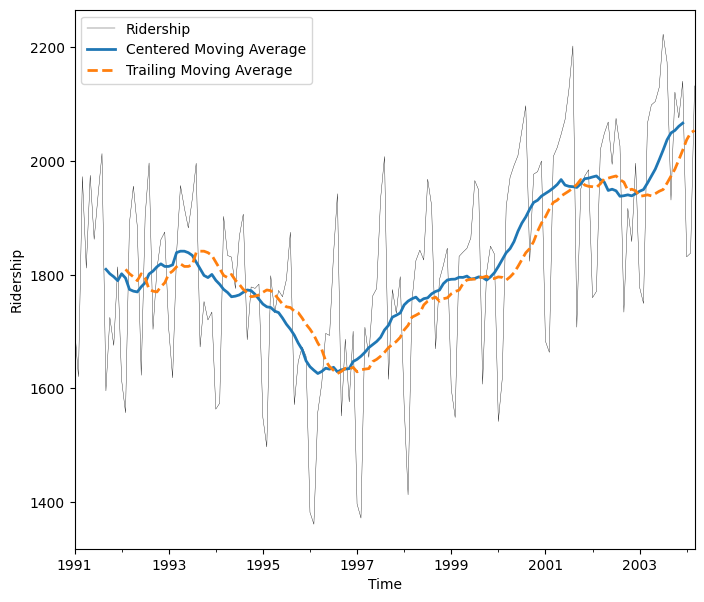

In [19]:
# shift the average by one time unit to get the next day prediction
ma_centered = pd.Series(ma_centered[:-1].values, index = ma_centered.index[1:])
ma_trailing = pd.Series(ma_trailing[:-1].values, index = ma_trailing.index[1:])

fig,ax = plt.subplots(figsize = (8,7))
ax = ridership_ts.plot(ax = ax, color = 'black', linewidth = 0.25)
ma_centered.plot(ax=ax, linewidth = 2)
ma_trailing.plot(ax=ax, style = '--', linewidth = 2)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership')
ax.legend(['Ridership', 'Centered Moving Average', 'Trailing Moving Average'])

plt.show()

# 12-month moving average forecaster

In [20]:
# create the plot
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1990','2004-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')

    # x좌표지정
    xtrain = (min(train_df.index), max(train_df.index)-one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index)-one_month)

    # 수직선 x좌표
    # train-validation
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])

    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos,ypos), c = 'black', linewidth = 0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos,ypos), c = 'black', linewidth = 0.5))
    ax.axvline(x=xtv, ymin = 0, ymax = 1, color = 'black', linewidth = 0.5)
    
    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('1995',ypos,'Training')
    ax.text('2002-3',ypos,'Validation')

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0],[1300,2550],train_df,valid_df)
    singleGraphLayout(axes[1],[-550,550],train_df,valid_df)
    train_df.plot(y = 'Ridership', ax = axes[0], color = 'C0', linewidth = 0.75)
    valid_df.plot(y = 'Ridership', ax = axes[0], color = 'C0', linestyle = 'dashed', linewidth = 0.75)
    axes[1].axhline(y = 0, xmin = 0, xmax = 1, color = 'black', linewidth = 0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend():
        axes[0].get_legend().remove()

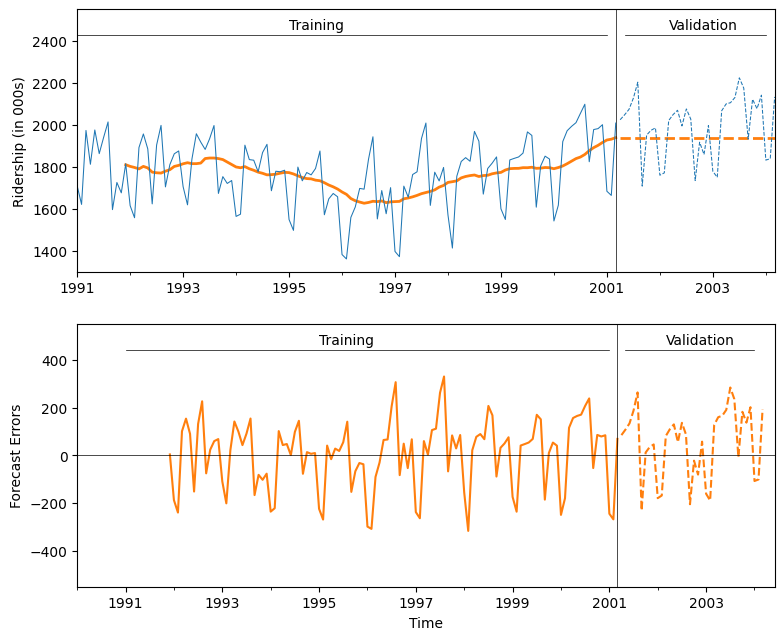

In [24]:
# partition the data
nValid = 36
nTrain = len(ridership_ts) - nValid

train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]

# moving average on training
ma_trailing = train_ts.rolling(12).mean()
last_ma = ma_trailing[-1]

# create forecast based on last moving average in the training period
ma_trailing_pred = pd.Series(last_ma, index = valid_ts.index)

fig,axes = plt.subplots(nrows=2, ncols = 1, figsize = (9,7.5))
ma_trailing.plot(ax = axes[0], linewidth = 2, color = 'C1')
ma_trailing_pred.plot(ax = axes[0], linewidth = 2, color = 'C1', linestyle = 'dashed')
residual = train_ts - ma_trailing
residual.plot(ax = axes[1], color = 'C1')
residual = valid_ts - ma_trailing_pred
residual.plot(ax = axes[1], color = 'C1', linestyle = 'dashed')
graphLayout(axes, train_ts, valid_ts)

# MA forecaster로 예측한 잔차를 회귀 모델의 결과에 더함으로써 예측 수행하기

In [25]:
# Build a model with seasonality, trend, and quadratic trend
ridership_df = tsatools.add_trend(ridership_ts, trend = 'ct')
ridership_df['Month'] = ridership_df.index.month

# Partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

formula = 'Ridership ~ trend + np.square(trend) + C(Month)'
ridership_lm_trendseason = sm.ols(formula = formula, data=train_df).fit()

# create single-point forecast
ridership_prediction = ridership_lm_trendseason.predict(valid_df.iloc[0,:])

# apply MA to residuals
ma_trailing = ridership_lm_trendseason.resid.rolling(12).mean()

print('prediction: ', ridership_prediction[0])
print('ma_trailing: ', ma_trailing[-1])
print('real_value: ', valid_df.iloc[0]['Ridership'].item())

prediction:  2004.270892764497
ma_trailing:  30.780684624060125
real_value:  2023.792


# Simple Exponential Smoothing으로 잔차 예측하기

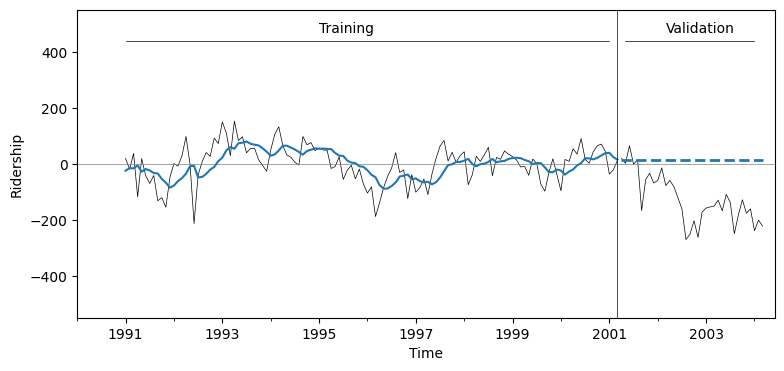

In [28]:
residuals_ts = ridership_lm_trendseason.resid
residuals_pred = valid_df.Ridership-ridership_lm_trendseason.predict(valid_df)

fig, ax = plt.subplots(figsize = (9,4))

ridership_lm_trendseason.resid.plot(ax = ax, color = 'black', linewidth = 0.5)
residuals_pred.plot(ax=ax, color = 'black', linewidth = 0.5)
ax.set_ylabel('Ridership')
ax.set_xlabel('Time')
ax.axhline(y = 0, xmin = 0, xmax = 1, color = 'gray', linewidth = 0.5)

# run exponential smoothing
# with smoothing level = alpha - 0.2
expSmooth = ExponentialSmoothing(residuals_ts, freq = 'MS')
expSmoothFit = expSmooth.fit(smoothing_level = 0.2)

expSmoothFit.fittedvalues.plot(ax=ax)
expSmoothFit.forecast(len(valid_ts)).plot(ax = ax, style = '--', linewidth = 2, color = 'C0')

singleGraphLayout(ax, [-550, 550], train_df, valid_df)

In [29]:
expSmoothFit.forecast(len(valid_ts))

2001-04-01    14.142855
2001-05-01    14.142855
2001-06-01    14.142855
2001-07-01    14.142855
2001-08-01    14.142855
2001-09-01    14.142855
2001-10-01    14.142855
2001-11-01    14.142855
2001-12-01    14.142855
2002-01-01    14.142855
2002-02-01    14.142855
2002-03-01    14.142855
2002-04-01    14.142855
2002-05-01    14.142855
2002-06-01    14.142855
2002-07-01    14.142855
2002-08-01    14.142855
2002-09-01    14.142855
2002-10-01    14.142855
2002-11-01    14.142855
2002-12-01    14.142855
2003-01-01    14.142855
2003-02-01    14.142855
2003-03-01    14.142855
2003-04-01    14.142855
2003-05-01    14.142855
2003-06-01    14.142855
2003-07-01    14.142855
2003-08-01    14.142855
2003-09-01    14.142855
2003-10-01    14.142855
2003-11-01    14.142855
2003-12-01    14.142855
2004-01-01    14.142855
2004-02-01    14.142855
2004-03-01    14.142855
Freq: MS, dtype: float64

# Double Exponential Smoothing

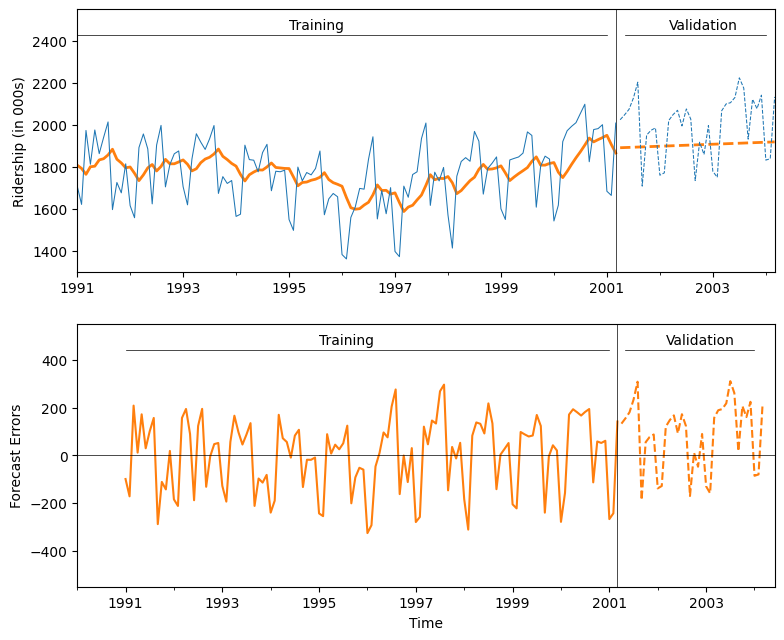

In [30]:
# run exponential smoothing with additive trend
expSmooth = ExponentialSmoothing(train_ts, trend='additive', seasonal = None, freq = 'MS')
expSmoothFit = expSmooth.fit()

fig, axes = plt.subplots(nrows = 2, ncols=1, figsize = (9,7.5))
expSmoothFit.fittedvalues.plot(ax = axes[0], linewidth = 2, color = 'C1')
expSmoothFit.forecast(len(valid_ts)).plot(ax = axes[0], linewidth = 2, color = 'C1',
                                         linestyle = 'dashed')
residual = train_ts - expSmoothFit.fittedvalues
residual.plot(ax = axes[1], color = 'C1')
residual = valid_ts - expSmoothFit.forecast(len(valid_ts))
residual.plot(ax=axes[1],color = 'C1',linestyle = 'dashed')
graphLayout(axes, train_ts, valid_ts)

# Holt-Winter’s Exponential Smoothing

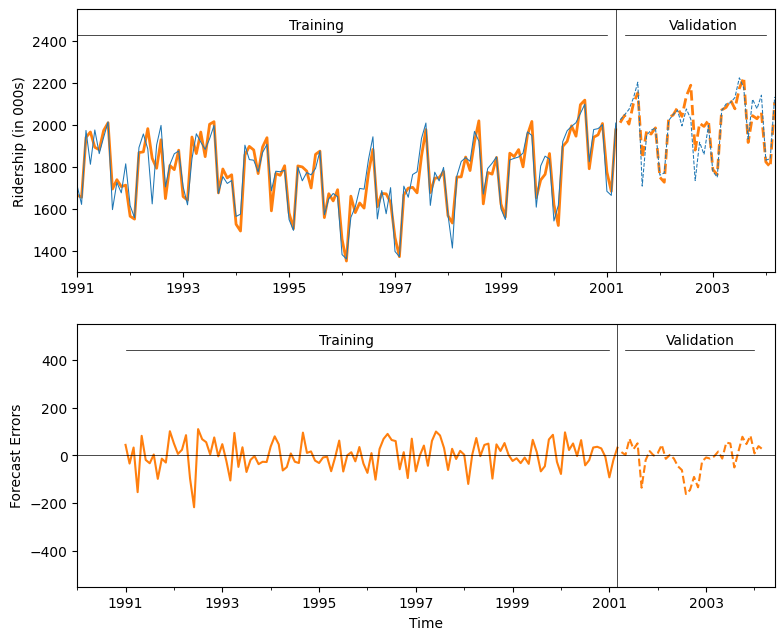

In [35]:
# run exponential smoothing with additive trend and additive seasonal
# 이전과 다른점
expSmooth = ExponentialSmoothing(train_ts, trend='additive', seasonal = 'additive',
                                 seasonal_periods=12, freq = 'MS')
expSmoothFit = expSmooth.fit()

fig, axes = plt.subplots(nrows = 2, ncols=1, figsize = (9,7.5))
expSmoothFit.fittedvalues.plot(ax = axes[0], linewidth = 2, color = 'C1')
expSmoothFit.forecast(len(valid_ts)).plot(ax = axes[0], linewidth = 2, color = 'C1',
                                         linestyle = 'dashed')
residual = train_ts - expSmoothFit.fittedvalues
residual.plot(ax = axes[1], color = 'C1')
residual = valid_ts - expSmoothFit.forecast(len(valid_ts))
residual.plot(ax=axes[1],color = 'C1',linestyle = 'dashed')
graphLayout(axes, train_ts, valid_ts)

In [41]:
for key,value in expSmoothFit.params.items():
    print(f'{key}: ',value)
print('AIC: ',expSmoothFit.aic)
print('AICc: ',expSmoothFit.aicc)
print('BIC: ',expSmoothFit.bic)

smoothing_level:  0.6779336489871308
smoothing_trend:  0.022067497192191393
smoothing_seasonal:  0.08042239139405516
damping_trend:  nan
initial_level:  1869.3122016053842
initial_trend:  -1.0276113975172674
initial_seasons:  [-203.76474858 -243.48364494   65.36624293   69.1288278   103.28817526
   37.17845381  143.14011263  204.16975028 -111.86705712    2.70643735
  -17.29645065   13.88534012]
use_boxcox:  False
lamda:  None
remove_bias:  False
AIC:  1033.192535401673
AICc:  1039.769458478596
BIC:  1078.1874850876316
